# Exercise 11: Adversarial Examples & Membership Inference

In [1]:
# Load packages we need
import sys
import os
import datetime

import numpy as np
import sklearn

import scipy as sp
import pandas as pd

import tensorflow as tf

# we'll use tensorflow and keras for neural networks
import tensorflow as tf
import tensorflow.keras as keras

# import layers we may use
from tensorflow.keras.layers import Input, Flatten, Reshape, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout

# import callbacks we may use
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 20})

# Let's check our software versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')


# load our packages / code
sys.path.insert(1, '../common/')
import utils
import plots
import nets

### Python version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
### Numpy version: 1.19.5
### Scikit-learn version: 0.24.1
### Tensorflow version: 2.4.1
------------


In [2]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42

# deterministic seed for reproducibility
np.random.seed(seed)
tf.random.set_seed(seed)

prop_vec = [24, 2, 2]

### Load MNIST data.

In [3]:
# grab the data
train_x, train_y, test_x, test_y, val_x, val_y, all_x, all_y = utils.load_preprocess_mnist_data(onehot=False, flatten=False, prop_vec=prop_vec, seed=seed)

# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((60000, 28, 28), (60000,), (5000, 28, 28), (5000,), (5000, 28, 28), (5000,))

In [4]:
# renormalize the data so all pixel values are in the [0,1] range 
train_x = (train_x / 255.0) 
test_x = (test_x / 255.0) 
val_x = (val_x / 255.0)

if len(train_x.shape) < 4:
    train_x = train_x.reshape(-1, 28, 28, 1)
    val_x = val_x.reshape(-1, 28, 28, 1)
    test_x = test_x.reshape(-1, 28, 28, 1)

In [5]:
def create_compile(input_shape=[28, 28, 1], num_outputs=10, verbose=False):
    
    name = 'FC'    
    model = keras.models.Sequential(name=name)
    
    model.add(Flatten(name='flatten', input_shape=input_shape))
    
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dropout(0.25, name='dropout1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    model.add(Dropout(0.25, name='dropout2'))
    model.add(Dense(64, activation='relu', name='fc3'))
    model.add(Dropout(0.25, name='dropout3'))
    
    model.add(Dense(num_outputs, activation="softmax", name='output'))
    
    opt = keras.optimizers.Adam(lr=0.002)
    
    if verbose:
        model.summary()
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

In [6]:
model_fp = 'mnist.h5'

load = os.path.exists(model_fp)

if load:
    model = keras.models.load_model(model_fp)
else:
    name, model = create_compile(verbose=True)

    early_stop_cb = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    max_epochs = 10
    batch_size = 32

    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size, 
                         shuffle=True, callbacks=[early_stop_cb])

    # save the model
    model.save(model_fp)
    
model.trainable = False

In [7]:
# get predicted label and confidence value for it
def pred_label_and_conf(model, x):
    preds = model.predict(x)[0]
    pred_label = np.argmax(preds)
    pred_conf = preds[pred_label]
    
    return pred_label, pred_conf

In [8]:
# for the attack we need to be able to get the gradient of the loss with respect to the input
def gradient_of_loss_wrt_input(model, in_x, y_target, num_classes=10):
    with tf.GradientTape() as tape:
        tape.watch(in_x) # tell the tape to watch in_x
        y_pred = model(in_x) # get the prediction on the model
        loss = keras.losses.sparse_categorical_crossentropy(y_target, y_pred) # compute the loss
        
    return tape.gradient(loss, in_x) # gradient of the loss with respect to the input

In [9]:
# Implementation of the Fast Gradient Sign Method (FGSM)
def do_fgsm(model, in_x, y_target, eps):
    grad_vec = gradient_of_loss_wrt_input(model, in_x, y_target)
    
    perturb = tf.sign(-grad_vec)
    adv_x = in_x + eps * perturb
    adv_x = tf.clip_by_value(adv_x, 0, 1.0) # clip
    
    return adv_x, perturb

### Let's create some adversarial examples

Epsilon: 0.001 --- 


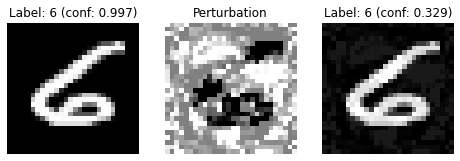


Epsilon: 0.01 --- 


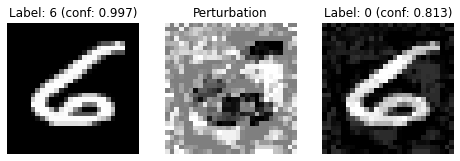


Epsilon: 0.02 --- 


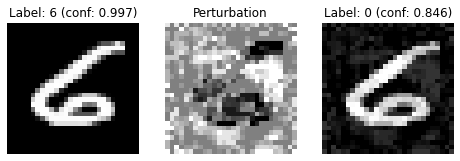


Epsilon: 0.05 --- 


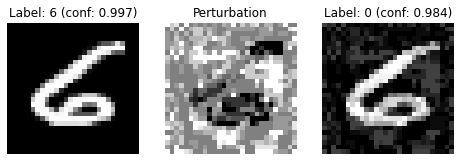


Epsilon: 0.1 --- 


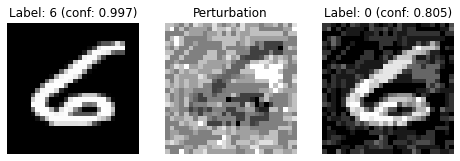

In [10]:
# pick a target
target_idx = 0
in_x = train_x[target_idx].reshape(1, 28, 28, 1)
in_y = train_y[target_idx]

_, in_conf = pred_label_and_conf(model, in_x)


# max number of iterations to do the attack
num_attack_iter = 100

# the target label we want the adversarial sample to be classified as
target_label = 0

# Once we reach this level of confidence we stop
conf_exit_early = 0.8

eps_vals = [0.001, 0.01, 0.02, 0.05, 0.1]
for i, eps in enumerate(eps_vals):
    
    # prepare the adversarial example
    # we need it to be a tensor so we can take the gradient of the loss with respect to it
    adv_x = tf.convert_to_tensor(in_x.reshape(1, 28, 28, 1), dtype=tf.float32)
    
    for i in range(0, num_attack_iter):
        # do one step of FGSM
        adv_x, _ = do_fgsm(model, adv_x, target_label, eps)
        
        # check if predicted label is the target
        adv_label, adv_conf = pred_label_and_conf(model, adv_x)
        
        # if so and confidence is above threshold, exit early
        if adv_label == target_label and adv_conf > conf_exit_early: 
            break
        
    # perturbation is just the difference between the adversarial sample and the starting data point
    perturb = adv_x - in_x
    
    titles = ['Label: {} (conf: {:.3f})'.format(in_y, in_conf), 'Perturbation',
              'Label: {} (conf: {:.3f})'.format(adv_label, adv_conf)]
    
    images = np.r_[in_x, perturb, adv_x]
    
    # plot images
    print('Epsilon: {} --- '.format(eps))
    plots.plot_images(images, dim_x=28, dim_y=28, fig_size=(8, 3), titles=titles, titles_fontsize=12)
    print()

### Can we get transferability?

#### Let's train another model wiht the same architecture

In [11]:
_, model2 = create_compile(verbose=True)

max_epochs = 20
batch_size = 64

history = model2.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size)

Model: "FC"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               200960    
_________________________________________________________________
dropout1 (Dropout)           (None, 256)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 128)               32896     
_________________________________________________________________
dropout2 (Dropout)           (None, 128)               0         
_________________________________________________________________
fc3 (Dense)                  (None, 64)                8256      
_________________________________________________________________
dropout3 (Dropout)           (None, 64)                0        

In [12]:
model2.trainable = False

# Compute predicted label and conf on model and model2
pred_label, pred_conf = pred_label_and_conf(model, adv_x)

print('Model predicted label: {} -- Confidence: {:.2f}%'.format(pred_label, 100.0*pred_conf))

pred_label, pred_conf = pred_label_and_conf(model2, adv_x)
print('Model2 predicted label: {} -- Confidence: {:.2f}%'.format(pred_label, 100.0*pred_conf))

Model predicted label: 0 -- Confidence: 80.46%
Model2 predicted label: 0 -- Confidence: 52.65%


## Privacy attacks

### Let's train an overfitted model

In [13]:
def create_compile(input_shape=[28, 28, 1], num_outputs=10, verbose=False):
    
    name = 'FC'    
    model = keras.models.Sequential(name=name)
    
    model.add(Flatten(name='flatten', input_shape=input_shape))
    
    model.add(Dense(4096, activation='relu', name='fc1'))
    
    model.add(Dense(num_outputs, activation="softmax", name='output'))
    
    opt = keras.optimizers.Adam(lr=0.001)
    
    if verbose:
        model.summary()
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return name, model

### We'll train the model only a subset of train_x

In [14]:
tr_sz = 500
tr_x = train_x[:tr_sz]
tr_y = train_y[:tr_sz]

# prepare an out set for evaluation
out_x = train_x[tr_sz:2*tr_sz]
out_y = train_y[tr_sz:2*tr_sz]

In [15]:
_, overfitted_model = create_compile(verbose=True)

Model: "FC"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              3215360   
_________________________________________________________________
output (Dense)               (None, 10)                40970     
Total params: 3,256,330
Trainable params: 3,256,330
Non-trainable params: 0
_________________________________________________________________


In [16]:
max_epochs = 100
batch_size = 32

history = overfitted_model.fit(tr_x, tr_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size)

Epoch 1/100
16/16 [==============================] - 1s 28ms/step - loss: 1.5604 - accuracy: 0.5163 - val_loss: 0.7133 - val_accuracy: 0.7726
Epoch 2/100
16/16 [==============================] - 0s 21ms/step - loss: 0.3507 - accuracy: 0.8890 - val_loss: 0.4782 - val_accuracy: 0.8590
Epoch 3/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0983 - accuracy: 0.9914 - val_loss: 0.4956 - val_accuracy: 0.8578
Epoch 4/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0497 - accuracy: 0.9998 - val_loss: 0.4730 - val_accuracy: 0.8646
Epoch 5/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0391 - accuracy: 0.9989 - val_loss: 0.5156 - val_accuracy: 0.8594
Epoch 6/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0291 - accuracy: 0.9955 - val_loss: 0.4612 - val_accuracy: 0.8710
Epoch 7/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.4790 - val_accuracy: 0.8742
Epoch 

16/16 [==============================] - 0s 22ms/step - loss: 1.3869e-04 - accuracy: 1.0000 - val_loss: 0.6084 - val_accuracy: 0.8758
Epoch 58/100
16/16 [==============================] - 0s 22ms/step - loss: 1.3246e-04 - accuracy: 1.0000 - val_loss: 0.6101 - val_accuracy: 0.8764
Epoch 59/100
16/16 [==============================] - 0s 21ms/step - loss: 1.3780e-04 - accuracy: 1.0000 - val_loss: 0.6119 - val_accuracy: 0.8766
Epoch 60/100
16/16 [==============================] - 0s 22ms/step - loss: 1.0733e-04 - accuracy: 1.0000 - val_loss: 0.6127 - val_accuracy: 0.8766
Epoch 61/100
16/16 [==============================] - 0s 20ms/step - loss: 1.0921e-04 - accuracy: 1.0000 - val_loss: 0.6140 - val_accuracy: 0.8766
Epoch 62/100
16/16 [==============================] - 0s 21ms/step - loss: 1.0553e-04 - accuracy: 1.0000 - val_loss: 0.6153 - val_accuracy: 0.8766
Epoch 63/100
16/16 [==============================] - 0s 20ms/step - loss: 1.1987e-04 - accuracy: 1.0000 - val_loss: 0.6165 - val_a

### Let's implement a simple attack

In [17]:
def simple_membership_inference_attack(model, targets_x, targets_y, threshold=0.9995):
    
    preds = model.predict(targets_x)
    pred_confs = preds[np.arange(preds.shape[0]), targets_y]
    membership_preds = (pred_confs > threshold).astype(int)
    
    return membership_preds, pred_confs

In [18]:
# prepare the target sets
targets_x = np.r_[tr_x, out_x]
targets_y = np.r_[tr_y, out_y]

# the true membership status (1 -> in, 0 -> out)
membership_true = np.r_[np.ones_like(tr_y), np.zeros_like(out_y)]

# perform the attack
membership_preds, pred_confs = simple_membership_inference_attack(overfitted_model, targets_x, targets_y)

# how accurate is the attack?
attack_acc = np.sum(membership_true == membership_preds) / membership_true.shape[0]
print('Attack accuracy: {:.2f}%'.format(100.0*attack_acc))

Attack accuracy: 70.80%


### Why does this even work?

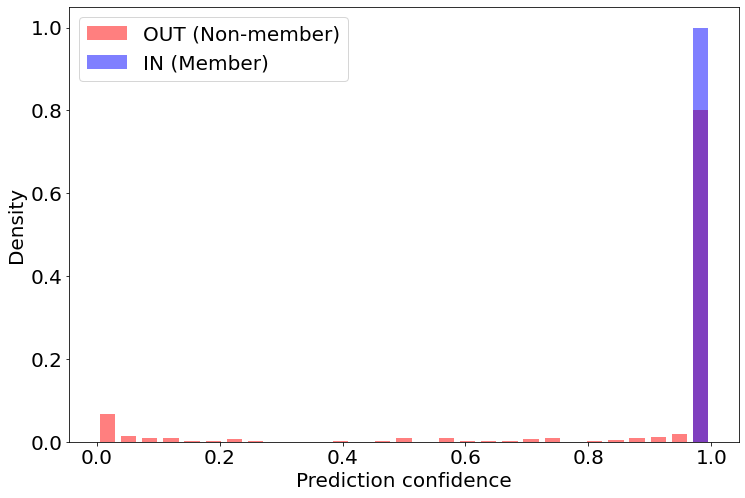

In [19]:
fig = plt.figure(figsize=(12,8))
bins = np.linspace(0, 1.0, 30)

ax = plt.gca()

out_data, bin_edges = np.histogram(pred_confs[membership_true == 0], bins, density=False)
in_data, bin_edges = np.histogram(pred_confs[membership_true == 1], bins, density=False)

bin_centers = bin_edges[:-1] + (bin_edges[1]-bin_edges[0])/2.0

ax.bar(bin_centers, out_data / np.sum(out_data), width=0.025, color='r', alpha=0.5, label='OUT (Non-member)')
ax.bar(bin_centers, in_data / np.sum(in_data), width=0.025, color='b', alpha=0.5, label='IN (Member)')

ax.set_xlabel('Prediction confidence')
ax.set_ylabel('Density')

plt.legend()
plt.show()